In [13]:
import numpy as np
import cv2 as cv
#from cv2 import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir, mkdir
from os.path import isfile, join, exists
import time
import random

from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score

%matplotlib inline

In [181]:
##################
def calc_SIFT(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    return keypoints, descriptors

# спочатку зберем наш датасет до купи


In [290]:
def prerare_data():
    x = []
    y = []
    for i in range(1, 7):
        tmp = []
        y_tmp = []
        for j in range(20):
            try:
                img = cv.imread(f'{i}/{j}.bmp')
                show_image(img)
                tmp.append(img)
                y_tmp.append(i)
            except: print(i, j)
        x.append(tmp)
        y.append(y_tmp)
    return x, y

In [291]:
def show_image(img):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

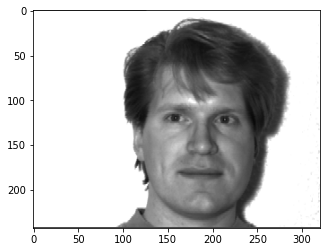

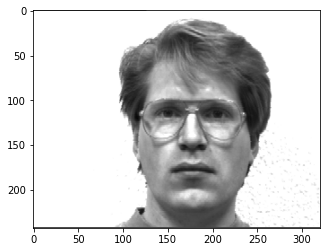

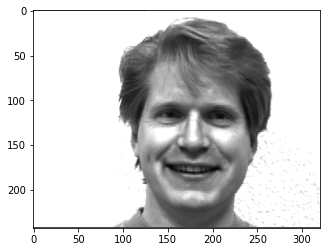

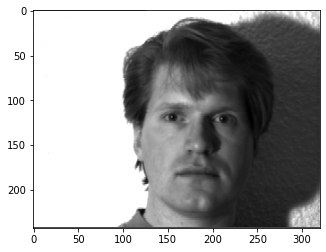

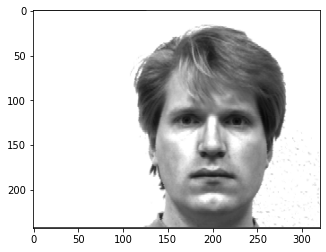

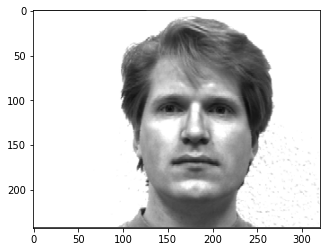

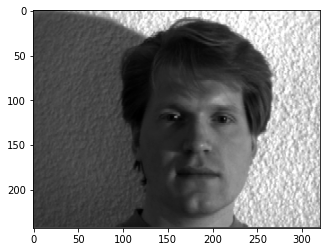

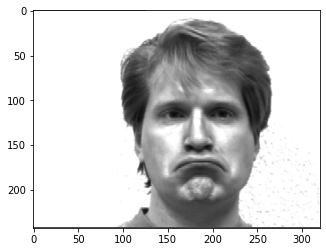

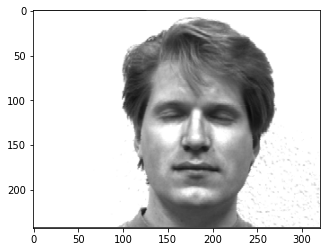

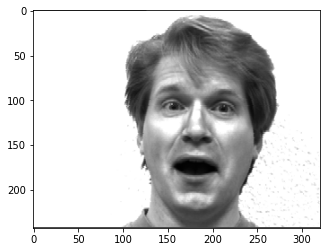

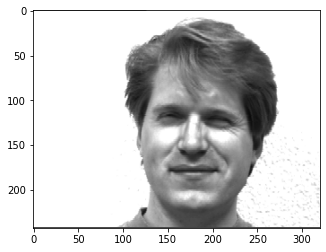

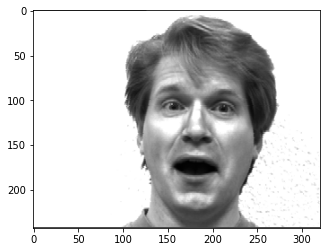

1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19


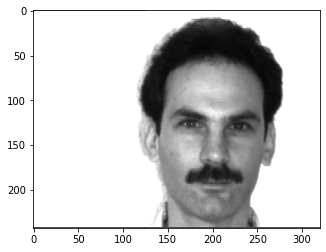

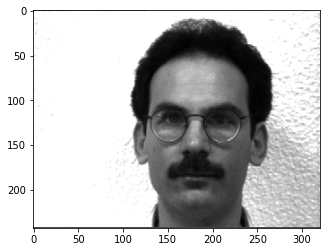

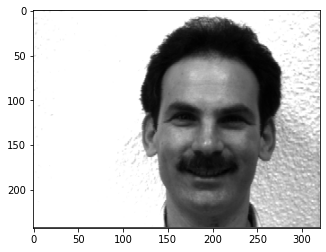

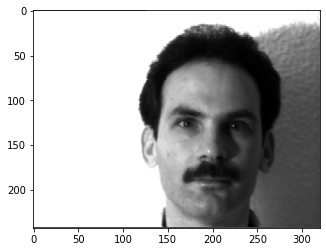

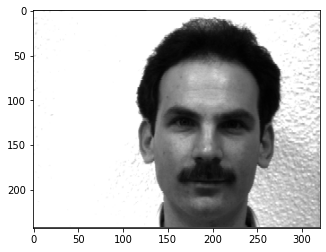

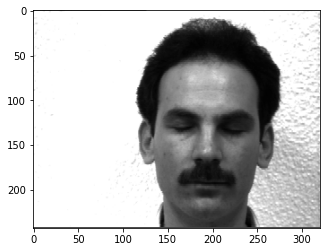

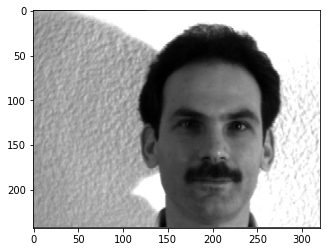

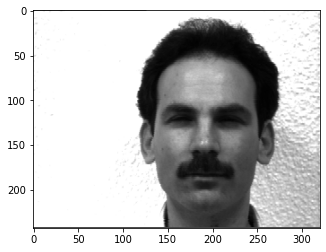

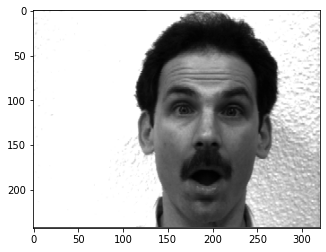

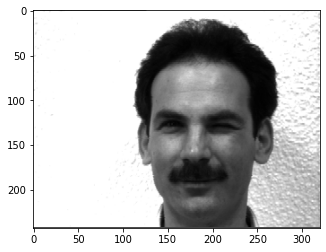

2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19


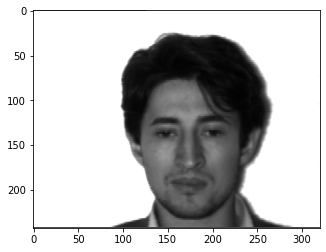

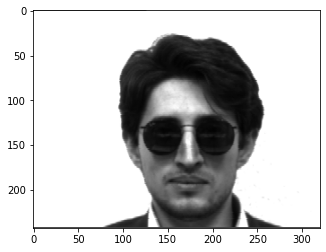

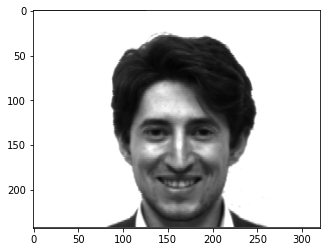

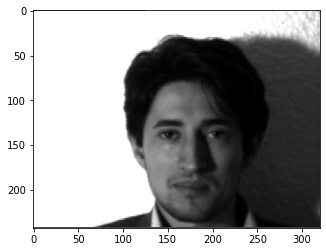

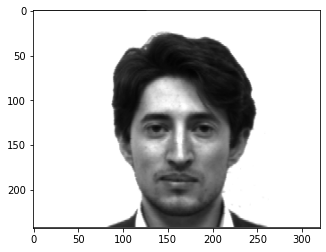

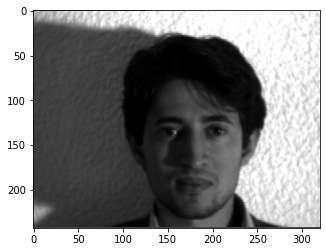

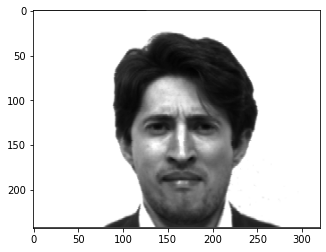

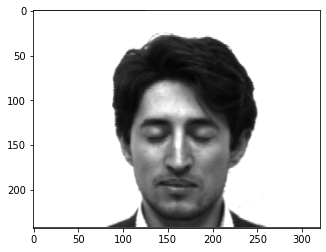

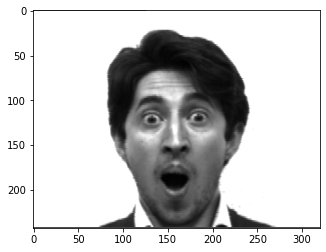

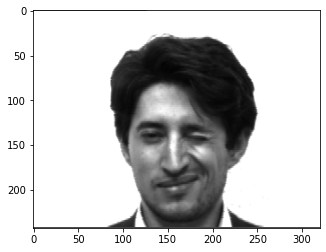

3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19


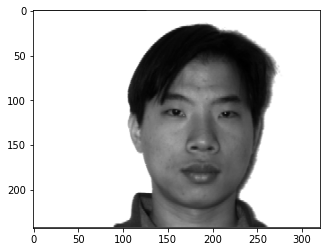

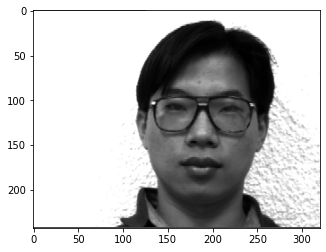

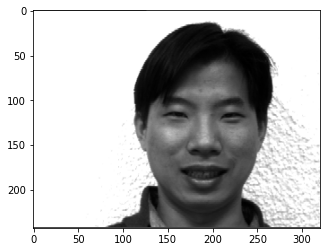

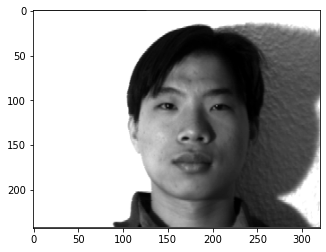

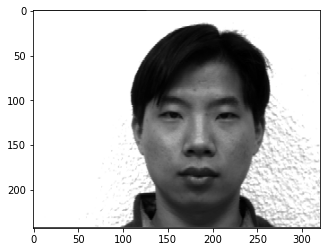

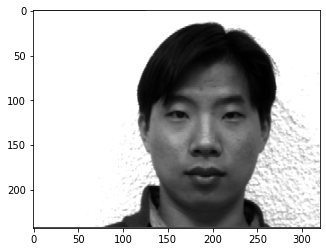

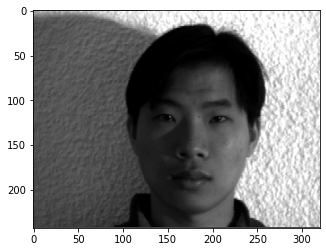

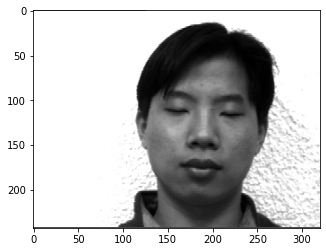

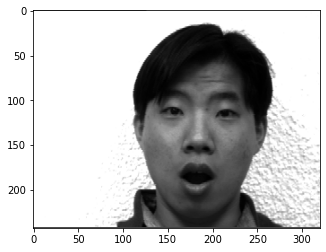

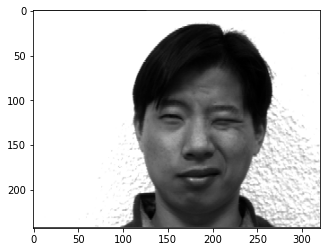

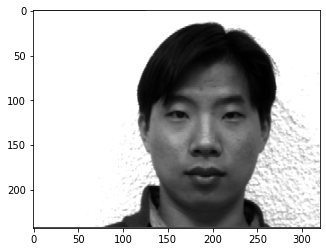

4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19


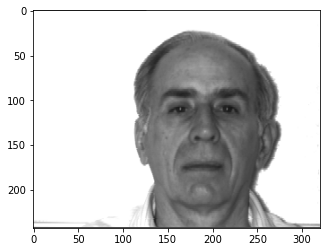

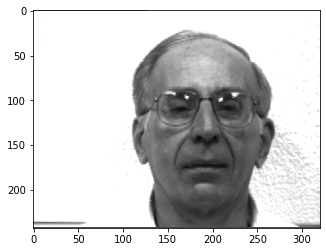

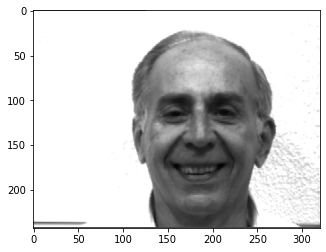

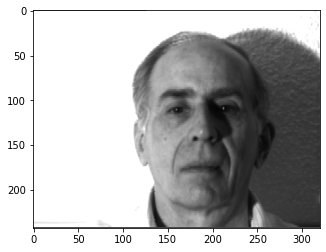

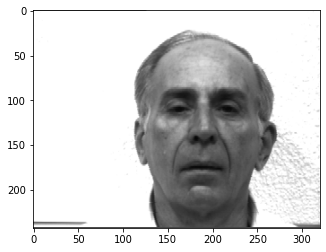

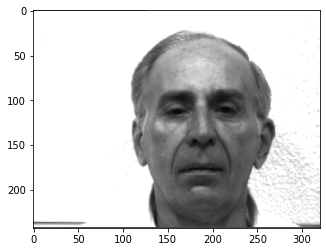

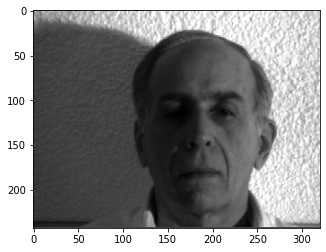

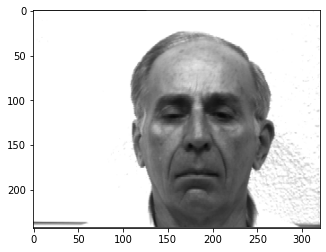

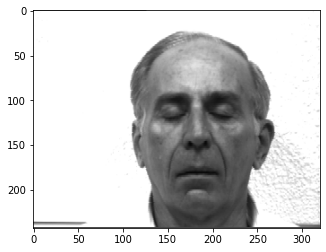

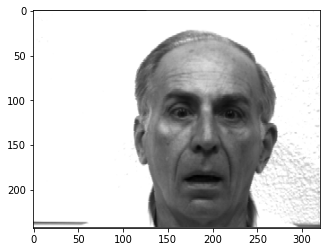

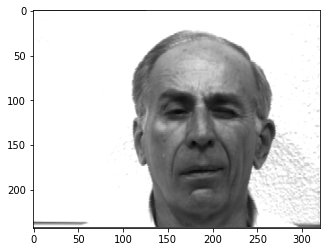

5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19


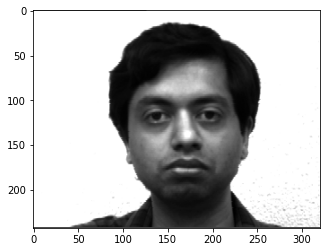

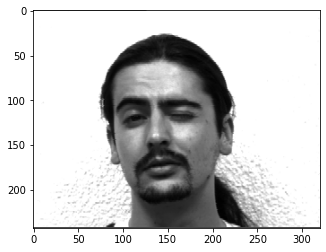

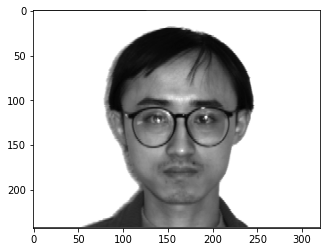

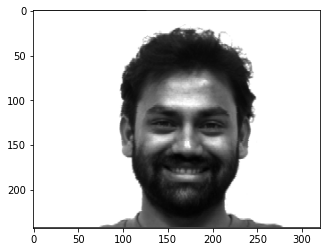

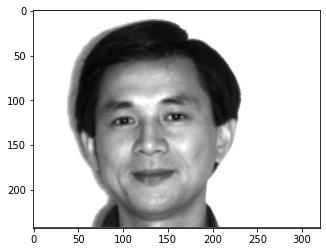

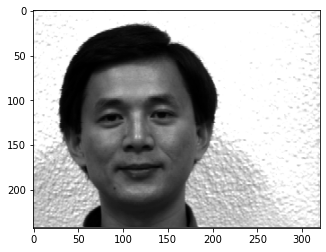

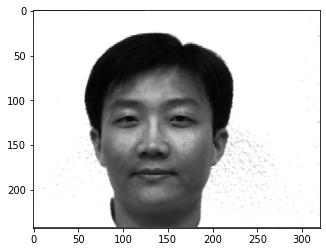

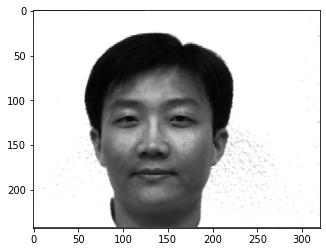

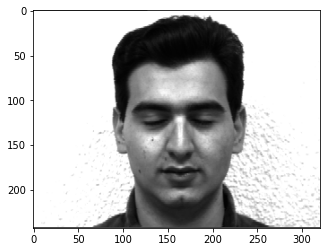

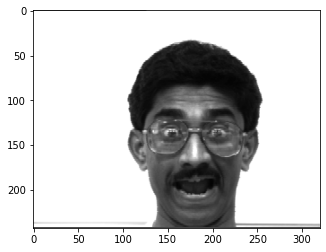

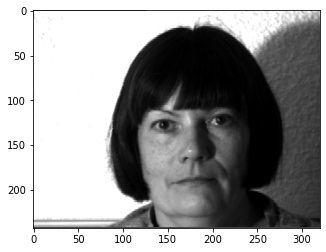

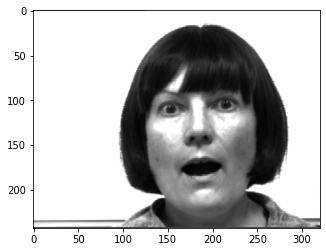

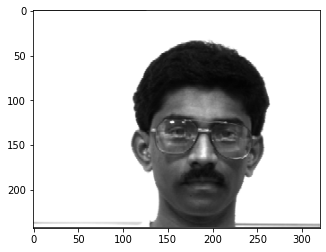

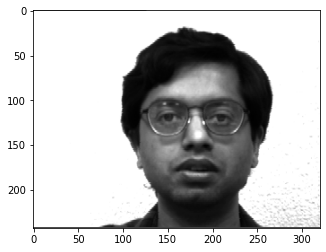

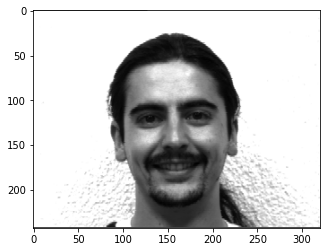

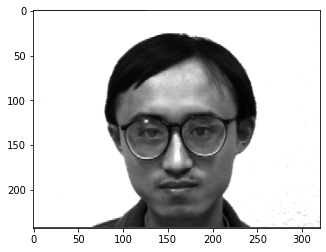

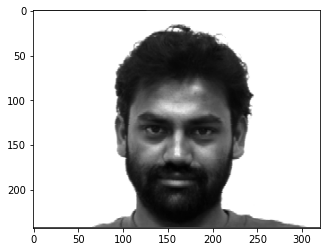

6 17
6 18
6 19


In [292]:
x, y = prerare_data()

Загальний датасет

In [293]:
data = []
for i in x:
    data += i

y_data = []
for i in y:
    y_data += i
    
x_train, x_test, y_train, y_test = train_test_split(data, y_data, test_size=0.25, random_state=42)

In [294]:
np.array(y_data).shape

(71,)

In [295]:
raw_x = np.array(x_train)[:,:,:,0].reshape((53, 243*320))
raw_y = np.array(y_train)

In [284]:
print(raw_x[1])

[130 130 130 ...  68  68  68]


In [214]:
def fit_bag_of_words(data, callable_descriptor):
    all_descriptors = []
    for idx, current_image in enumerate(data):
        keypoints, descriptors = callable_descriptor(current_image)
        all_descriptors.extend(descriptors)
    
    # count of clusters
    k = 100
    kmeans = KMeans(n_clusters=k, verbose=False).fit(all_descriptors)
    
    return kmeans

In [215]:
k_means_train_sift = fit_bag_of_words(x_train, calc_SIFT)

In [232]:
def picture_to_vector(picture, k_means_pretrained, callable_descriptor, k_cluster=100):
    keypoints, descriptors = callable_descriptor(picture)
    histogram = np.zeros(k_cluster)
    kp_count = len(keypoints)
    
    for d in descriptors:
        idx = k_means_pretrained.predict([d])
        histogram[idx] += 1.0 / kp_count
        
    return histogram * 50
    

In [233]:
x_train_vec_sift = np.array([picture_to_vector(pic, k_means_train_sift, calc_SIFT) for pic in x_train])
x_test_vec_sift = np.array([picture_to_vector(pic, k_means_train_sift, calc_SIFT) for pic in x_test])

Теперь обучим классификаторы Quadratic classifier, Gaussian Process Classifier

In [234]:
x_train_vec_sift.shape

(53, 500)

In [296]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

In [297]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        # <your code. Try np.maximum>
        return (np.maximum(0, input))
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad        

In [298]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. We use normal initialization, 
        # but surely there is something better. Try this once you got it working: http://bit.ly/2vTlmaJ
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input, self.weights ) + self.biases #<your code here>
    
    def backward(self,input,grad_output):
        
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T) #<your code here>
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output) #<your code here>
        
        grad_biases = np.dot(np.ones(len(input[:, 0])), grad_output) #<your code here>
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [299]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [300]:
network = []
network.append(Dense(raw_x.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,50))
network.append(ReLU())
network.append(Dense(50,300))
network.append(ReLU())
network.append(Dense(300,10))

Теперь напишем функцию, которая делает предсказания на тестовой выборке, и считает accuracy, false-positive,
false-negative и время обработки тестового датасета.

In [301]:
def false_positive(y_true, y_pred):
    result = 0
    result_idx = []
    for i in range(len(y_true)):
        if y_pred[i] == 1 and y_true[i] == 0:
            result += 1
            result_idx.append(i)
    return result, result_idx

In [302]:
def false_negative(y_true, y_pred):
    result = 0
    result_idx = []
    for i in range(len(y_true)):
        if y_pred[i] == 0 and y_true[i] == 1:
            result += 1
            result_idx.append(i)
    return result, result_idx

In [303]:
class PredictResult:
    def __init__(self, accuracy, mean_time, false_negative_score, false_positive_score):
        self.accuracy = accuracy
        self.mean_time = mean_time
        self.false_negative_score = false_negative_score
        self.false_positive_score = false_positive_score
        
    def print_result(self):
        print('Accuracy =', self.accuracy)
        print('Mean time =', self.mean_time)
        print('False negative score =', self.false_negative_score)
        print('False positive score =', self.false_positive_score)

In [304]:
def predict_probability(pretrained_clf, x_test, y_true):
    start_time = time.time()
    #y_predict_proba = pretrained_clf.predict_proba(x_test_vec_sift)
    y_predict = pretrained_clf.predict(x_test)
    end_time = time.time() - start_time
    accuracy = accuracy_score(y_true, y_predict)
    mean_time = end_time / x_test.shape[0]
    false_negative_score = false_negative(y_true, y_predict)[0]
    false_positive_score = false_positive(y_true, y_predict)[0]
    
    return y_predict, PredictResult(accuracy, mean_time, false_negative_score, false_positive_score)

In [305]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X
    for nt in network:
        input = nt.forward(input)
        activations.append(input)
    # <your code here>
        
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # <your code: propagate gradients through the network>
    for i in reversed(range(len(network))):
        loss_grad = network[i].backward(layer_inputs[i], loss_grad)
        
    return np.mean(loss)

In [306]:
from IPython.display import clear_output
train_log = []
val_log = []

In [307]:
last = network[2].weights

[[ 0.00667467 -0.00640343 -0.00610234 ... -0.00753808 -0.01961808
   0.00369794]
 [ 0.00246825  0.00498533  0.01449895 ... -0.00150699 -0.01061792
  -0.00527597]
 [-0.00863114 -0.00953921  0.00248782 ... -0.01409062  0.02398625
   0.00847379]
 ...
 [ 0.01501253  0.01324572 -0.0185025  ...  0.01225209 -0.00204782
   0.00635045]
 [-0.02140123 -0.01815847  0.00977085 ...  0.01890142  0.00190299
  -0.00715024]
 [ 0.00820248 -0.00319039  0.00398781 ... -0.00449839  0.018212
   0.01631722]]
Epoch 0
Train accuracy: 0.2641509433962264
Val accuracy: 0.2641509433962264


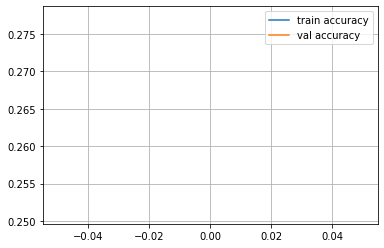

[[ 0.00667467 -0.00758395 -0.00610234 ... -0.00785039 -0.01956618
   0.00369794]
 [ 0.00246825  0.00489578  0.01449895 ... -0.00135556 -0.01065733
  -0.00527597]
 [-0.00863114 -0.00956228  0.00248782 ... -0.01407322  0.02398814
   0.00847379]
 ...
 [ 0.01501253  0.01303598 -0.0185025  ...  0.012161   -0.00191965
   0.00635045]
 [-0.02140123 -0.02232016  0.00977085 ...  0.01842796  0.00189796
  -0.00715024]
 [ 0.00820248 -0.00316317  0.00398781 ... -0.00434515  0.01825037
   0.01631722]]
Epoch 1
Train accuracy: 0.2641509433962264
Val accuracy: 0.2641509433962264


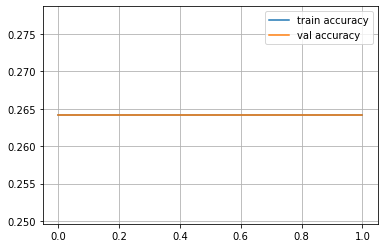

[[ 0.01676702 -0.0071531  -0.00610234 ... -0.00785039 -0.05409981
   0.00369794]
 [ 0.00246825  0.00489578  0.01449895 ... -0.00135556 -0.01065733
  -0.00527597]
 [-0.00863114 -0.00956228  0.00248782 ... -0.01407322  0.02398814
   0.00847379]
 ...
 [ 0.02217214  0.01328546 -0.0185025  ...  0.012161   -0.02349946
   0.00635045]
 [ 0.00544924 -0.02110891  0.00977085 ...  0.01842796 -0.0858845
  -0.00715024]
 [ 0.00820248 -0.00316317  0.00398781 ... -0.00434515  0.01825037
   0.01631722]]
Epoch 2
Train accuracy: 0.11320754716981132
Val accuracy: 0.11320754716981132


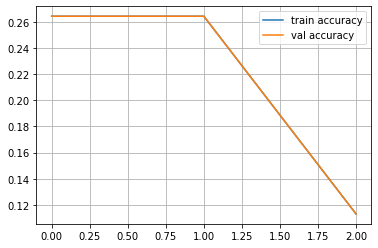

[[ 0.01676702 -0.0071531  -0.00610234 ... -0.00785039 -0.05409981
   0.00369794]
 [ 0.00246825  0.00489578  0.01449895 ... -0.00135556 -0.01065733
  -0.00527597]
 [-0.00747918 -0.00956228  0.00033249 ... -0.01407322  0.02398814
   0.00878452]
 ...
 [ 0.02217214  0.01328546 -0.0185025  ...  0.012161   -0.02349946
   0.00635045]
 [ 0.00544924 -0.02110891  0.00977085 ...  0.01842796 -0.0858845
  -0.00715024]
 [ 0.00820248 -0.00316317  0.00398781 ... -0.00434515  0.01825037
   0.01631722]]
Epoch 3
Train accuracy: 0.1509433962264151
Val accuracy: 0.1509433962264151


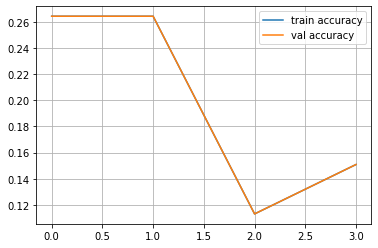

[[ 1.67670185e-02 -7.15310318e-03 -6.10234195e-03 ... -7.85038589e-03
  -5.40998075e-02  3.69793875e-03]
 [ 2.46825198e-03  4.89577927e-03  1.44989490e-02 ... -1.35555619e-03
  -1.06573349e-02 -5.27597173e-03]
 [-7.47917912e-03 -1.51929108e+00 -9.62129295e-01 ... -1.40732209e-02
   2.39881411e-02  1.47477200e+00]
 ...
 [ 2.21721364e-02  1.32854575e-02 -1.85024970e-02 ...  1.21610034e-02
  -2.34994556e-02  6.35045400e-03]
 [ 5.44924044e-03 -2.11089119e-02  9.77085294e-03 ...  1.84279558e-02
  -8.58844962e-02 -7.15024028e-03]
 [ 8.20247923e-03 -3.16316794e-03  3.98781003e-03 ... -4.34515297e-03
   1.82503685e-02  1.63172244e-02]]
Epoch 4
Train accuracy: 0.16981132075471697
Val accuracy: 0.16981132075471697


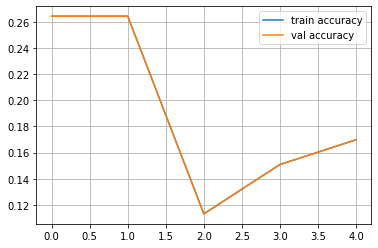

<ipython-input-299-f379f7781f62>:4: RuntimeWarning: overflow encountered in exp
  xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
<ipython-input-299-f379f7781f62>:12: RuntimeWarning: overflow encountered in exp
  softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
<ipython-input-299-f379f7781f62>:12: RuntimeWarning: invalid value encountered in true_divide
  softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Epoch 5
Train accuracy: 0.0
Val accuracy: 0.0


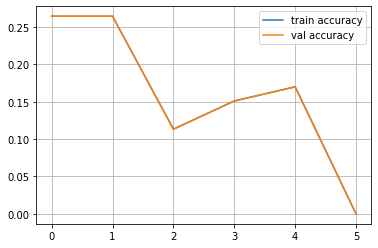

<ipython-input-297-3a82e34525ba>:13: RuntimeWarning: invalid value encountered in greater
  relu_grad = input > 0


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Epoch 6
Train accuracy: 0.0
Val accuracy: 0.0


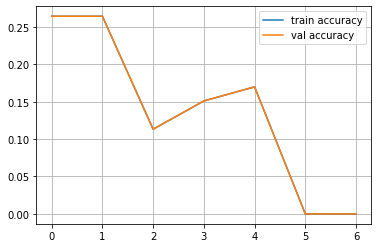

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Epoch 7
Train accuracy: 0.0
Val accuracy: 0.0


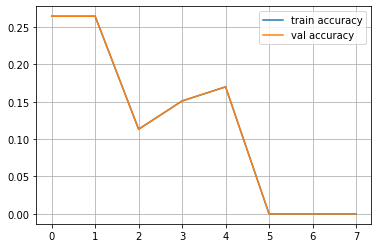

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Epoch 8
Train accuracy: 0.0
Val accuracy: 0.0


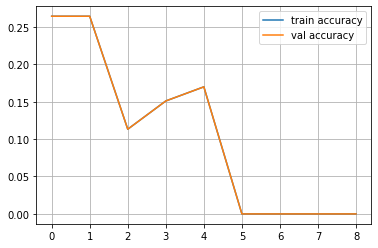

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Epoch 9
Train accuracy: 0.0
Val accuracy: 0.0


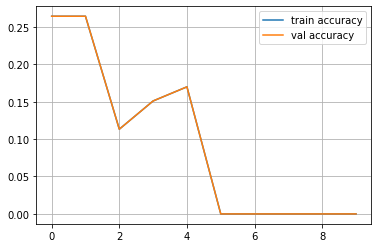

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Epoch 10
Train accuracy: 0.0
Val accuracy: 0.0


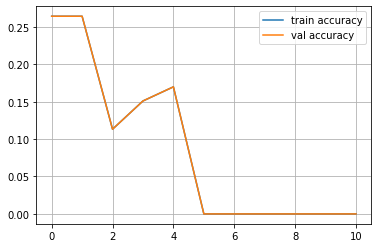

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Epoch 11
Train accuracy: 0.0
Val accuracy: 0.0


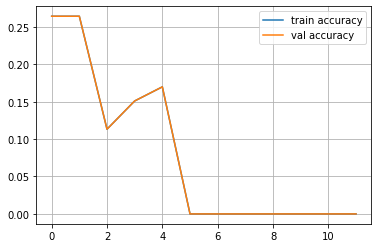

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Epoch 12
Train accuracy: 0.0
Val accuracy: 0.0


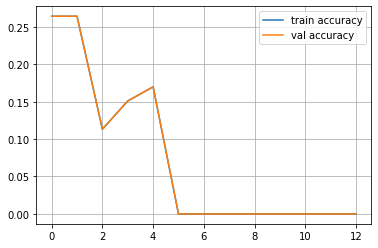

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Epoch 13
Train accuracy: 0.0
Val accuracy: 0.0


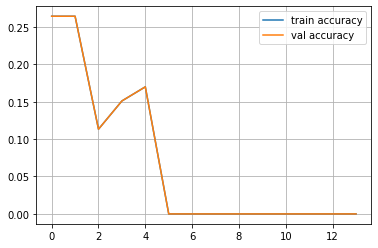

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Epoch 14
Train accuracy: 0.0
Val accuracy: 0.0


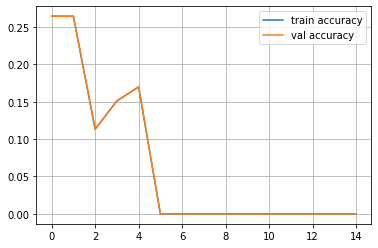

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Epoch 15
Train accuracy: 0.0
Val accuracy: 0.0


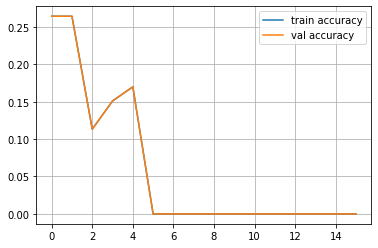

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Epoch 16
Train accuracy: 0.0
Val accuracy: 0.0


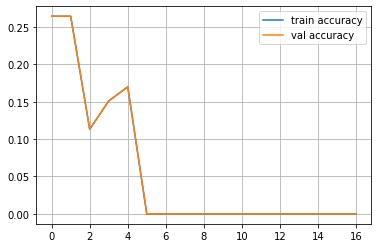

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Epoch 17
Train accuracy: 0.0
Val accuracy: 0.0


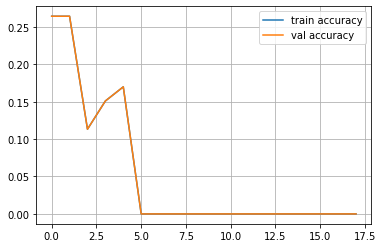

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Epoch 18
Train accuracy: 0.0
Val accuracy: 0.0


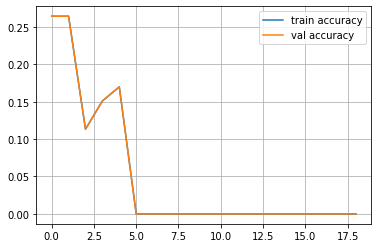

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Epoch 19
Train accuracy: 0.0
Val accuracy: 0.0


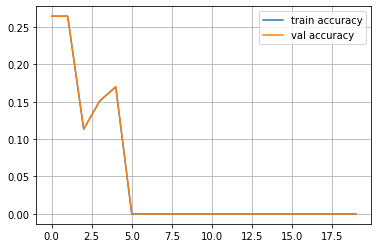

In [308]:
for epoch in range(20):

    
    train(network,raw_x,y_train)
    print(network[2].weights)
    #last = network[2].weights
    
    train_log.append(np.mean(predict(network,raw_x)==raw_y))
    val_log.append(np.mean(predict(network,raw_x)==raw_y))
    
    #clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

Теперь сделаем предсказания с помощью двух классификаторов и посмотрим на результаты:

In [87]:
quadratic_clf_pred, quadratic_result = predict_probability(quadratic_clf, x_test_vec_sift, y_test1)
gaussian_process_clf_pred, gaussian_process_result = predict_probability(gaussian_process_clf, x_test_vec_akaze, y_test2)
#svc_clf_pred, svc_result = predict_probability(svc_clf, x_test_vec_sift, y_test)

Посмотрим на результаты работы Quadratic classifier

In [97]:
quadratic_result.print_result()

Accuracy = 0.8198198198198198
Mean time = 8.187852464280687e-06
False negative score = 0
False positive score = 20


Мы получили хорошую точность класификации, а учитывая, что у нас достаточно сбалансированые классы (50/50),
можно считать это надежным показателем качества модели. Также среднее время обработки одной картинки очень мало, что позволит обрабатывать большие объемы данных, но стоит заметит,ь что значительные вычислительные ресурсы трятатся на этапе получения векторного представления картинки. И мы получили 2 false positive результата, посмотрим на них.

In [120]:
false_positive_idx = false_positive(y_test1, quadratic_clf_pred)[1]

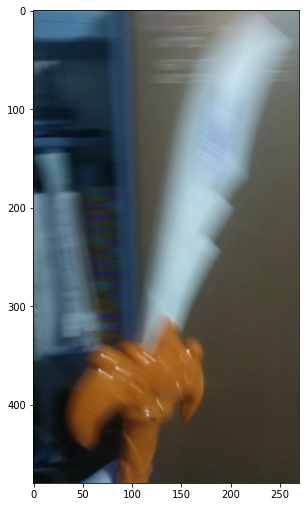

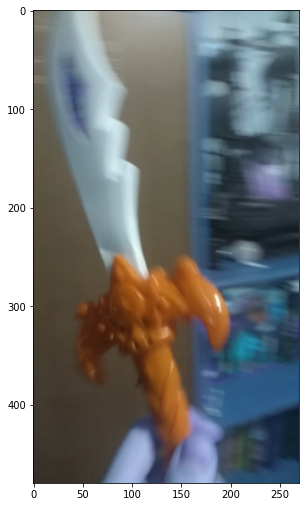

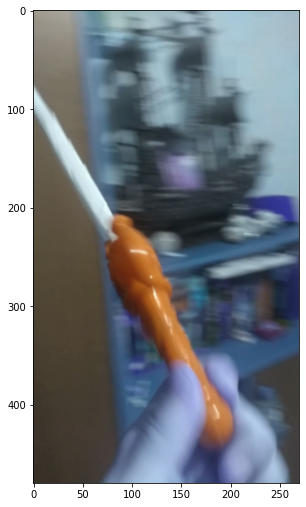

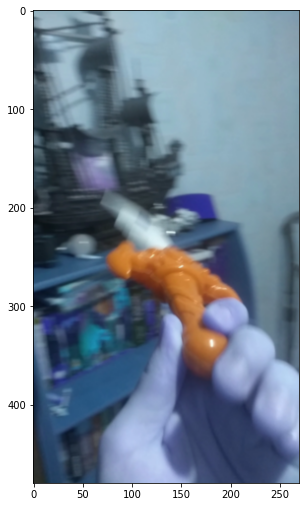

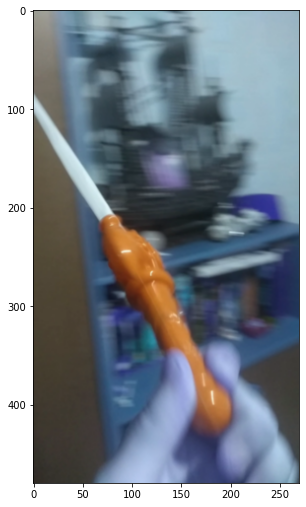

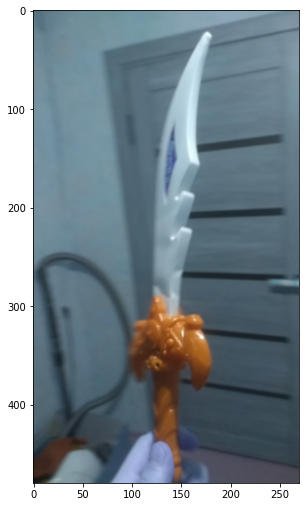

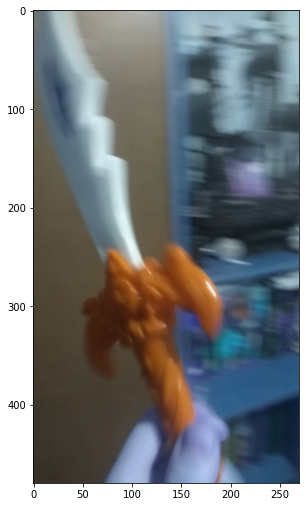

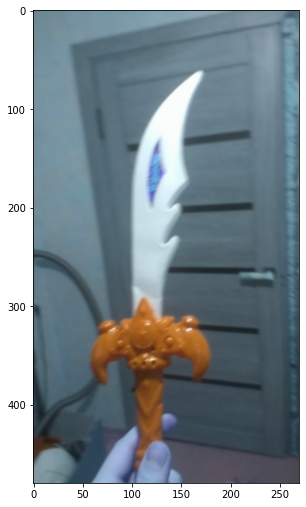

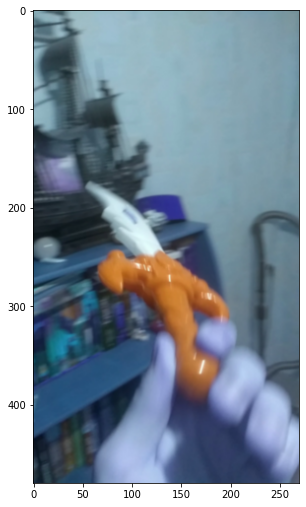

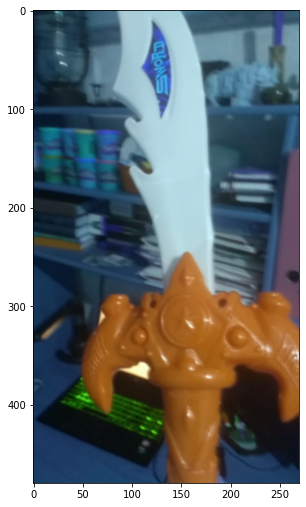

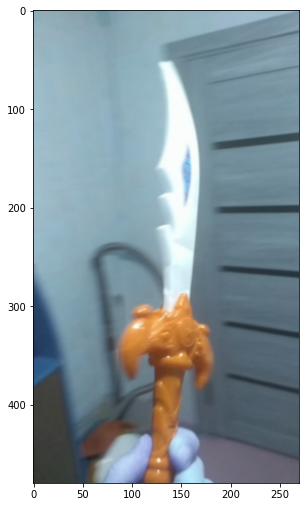

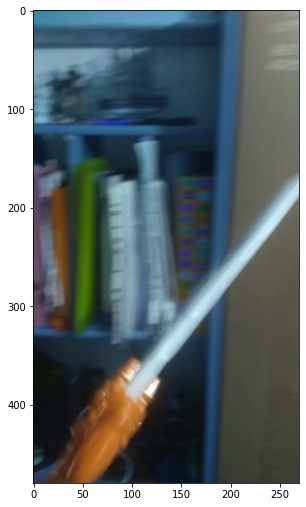

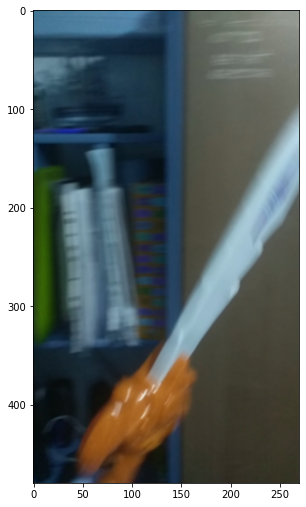

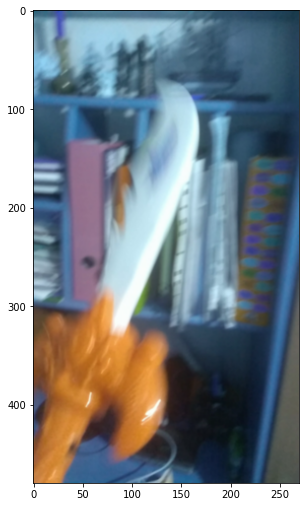

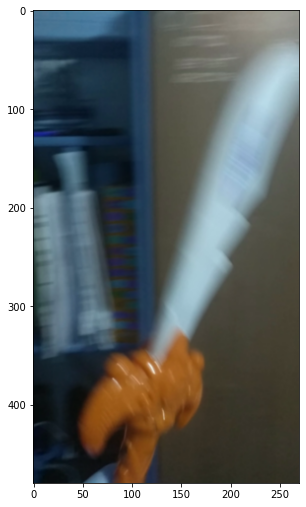

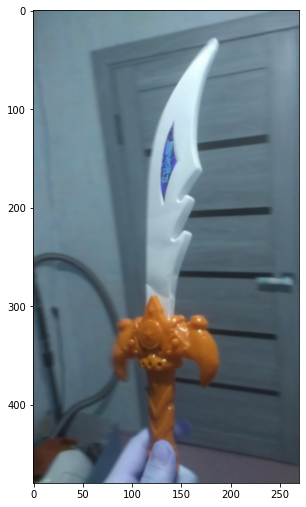

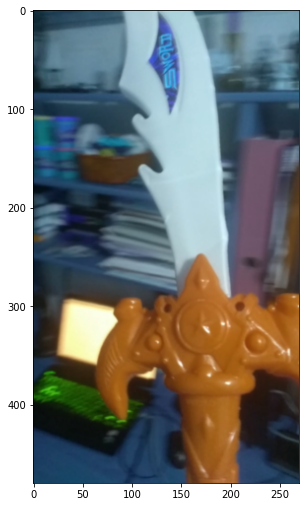

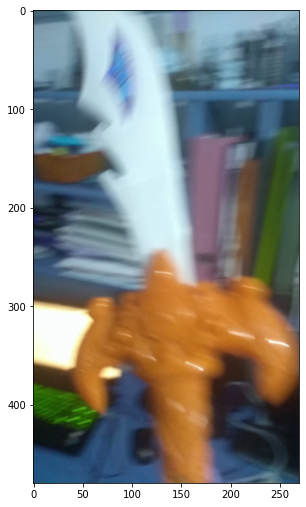

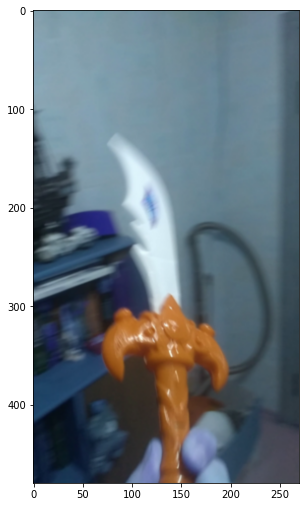

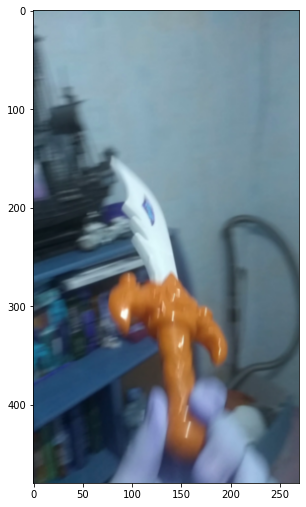

In [121]:
for i in range(len(false_positive_idx)):
    plt.figure(figsize=(60, 40))
    plt.subplot(4,5,i + 1)
    plt.imshow(x_test1[false_positive_idx[i]])

Как видим на этих картинках наш классификатор идентифицирует ложное присутствие предмета. Хотя на половине семплов действительно есть корабль на фоне, значит наш классификатор умеет находить разніе корабли!! Плюс мы не имеем ни одного ложно негативного срабатывания.

Посмотрим на результаты работы Gaussian Process Classifier

In [122]:
gaussian_process_result.print_result()

Accuracy = 0.9099099099099099
Mean time = 1.2969111537074184e-05
False negative score = 4
False positive score = 6


Как видим, мы имеем так же достаточно хорошее качество, и сравнительно маленькое время обработки изображения. Мы получили 6 ложно положительньіх срабатываний и 4 ложно отрицательньіх.

Посмотрим на ложно отрицательньій результат:

In [123]:
false_negative_idx = false_negative(y_test2, gaussian_process_clf_pred)[1]

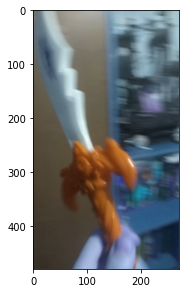

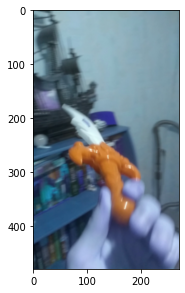

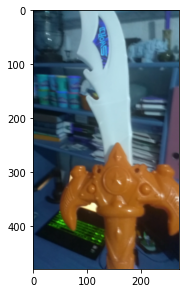

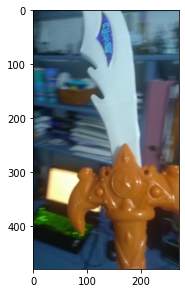

In [124]:
for i in range(len(false_negative_idx)):
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 4, i + 1)
    plt.imshow(x_test1[false_negative_idx[i]])

Как видим, обьект здесь под разньіми углами и не полностю в кадре, что можно простить

Ложно положительное срабатывание:

In [125]:
false_positive_idx = false_positive(y_test2, gaussian_process_clf_pred)[1]

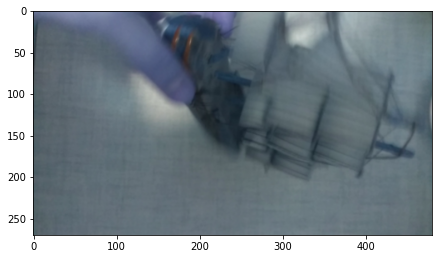

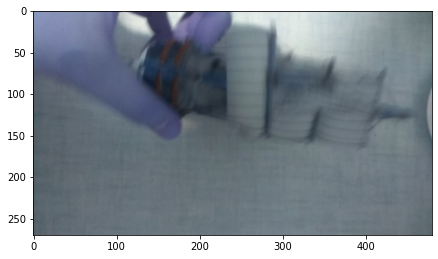

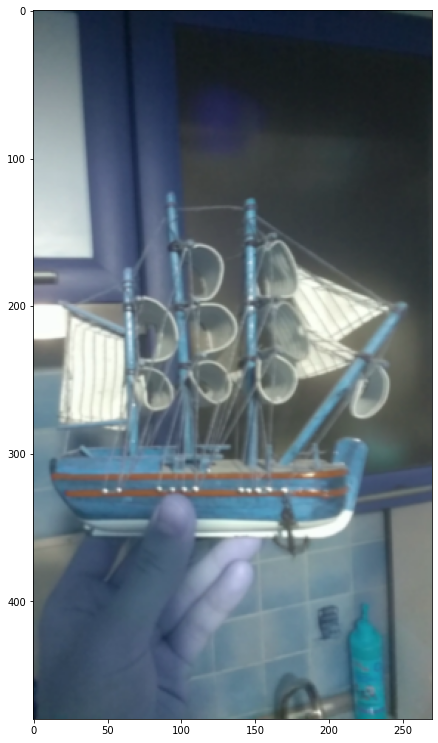

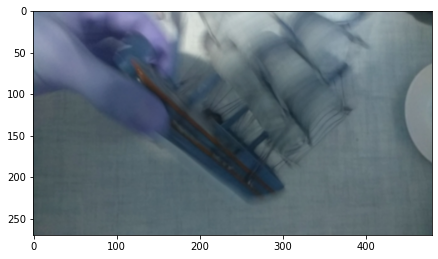

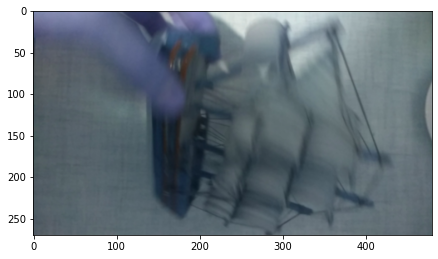

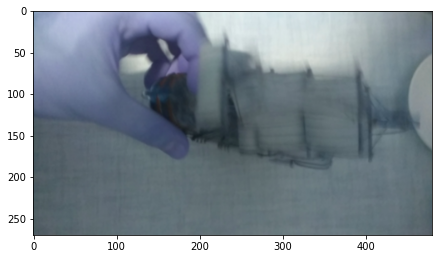

In [128]:
for i in range(len(false_positive_idx)):
    plt.figure(figsize=(50, 40))
    plt.subplot(1, 6, i + 1)
    plt.imshow(x_test1[false_positive_idx[i]])

Можно сделать вывод, что для успешной классификации необходим рациональный подход к выбору и обучению классификатора. Что мы успешно и продемонстрировали в работе.

Теперь перейдем к части, где мы будем пытаться обнаружить наш предмет на видео.

Сначала напишем техническую функцию-генератор, которая будет обходить матрицу (изображение) скользящим окном заднного размера.

In [47]:
def correct_slice(current_x, current_y, x_size, y_size, matrix_shape):
    return (current_x + x_size - 1 < matrix_shape[0]) and (current_y + y_size - 1 < matrix_shape[1])

def sliding_window(mtx, x_size, y_size, dx_step, dy_step):
    current_x, current_y = (0, 0)
    while True:
        if not correct_slice(current_x, current_y, x_size, y_size, mtx.shape):
            break
        
        yield current_x, current_y, mtx[current_x: current_x + x_size, current_y: current_y + y_size]
        
        if current_x + dx_step  < mtx.shape[0] and correct_slice(current_x + dx_step, current_y, x_size, y_size, mtx.shape):
            current_x += dx_step
        elif current_y + dy_step < mtx.shape[1] and correct_slice(current_x, current_y + dy_step, x_size, y_size, mtx.shape):
            current_x = 0
            current_y += dy_step
        else:
            break

In [49]:
def gauss_filter(img):
    return cv.GaussianBlur(img, (5,5), 0).clip(0, 255).astype(np.uint8)

Опишем процесс детекции предмета на видео. Очевидно, видео разбивается на кадры и детекцию проводим в пределах каждого кадра. Кадр мы обходим скользящим окном, и на скользящее окно смотрим как на новое изображение на котором мы и будем искать банку рево. Используя ранее обученный bag of words переводим это изображение (скользящее окно) в векторное представление и с помощью ранее обученного классификатора предсказываем принадлежность нашому классу. И среди всех таких скользящих окном выбираем то, где принадлежность к нашему классу максимальная, и по контурам этого окна рисуем прямоугольник, таким образом получаем детекцию предмета на видео.

In [133]:
cap = cv.VideoCapture('sword2.mp4')
full_hd_shape = (1080, 1920)
#vid = cv.VideoWriter('out1.mp4', cv.VideoWriter_fourcc(*'mp4v'), 24, full_hd_shape, True)
fourcc = cv.VideoWriter_fourcc(*'XVID')
vid = cv.VideoWriter('out2.avi',fourcc, 20.0, (1080,1920))

sliding_window_sizes = [(700, 700), (700, 700)]
step_dx = full_hd_shape[1] // 5
step_dy = full_hd_shape[0] // 5

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        best_proba = 0
        best_curr_x, best_curr_y = None, None
        best_sl_size = None, None
        frame = gauss_filter(frame)
        for sliding_window_size in sliding_window_sizes:
            for curr_x, curr_y, subwindow in sliding_window(frame, *sliding_window_size, step_dx, step_dy):
                try:
                    subwindow_vector_representation = picture_to_vector(subwindow, k_means_train_sift, calc_SIFT)
                    pred_proba = gaussian_process_clf.predict_proba([subwindow_vector_representation])[0][1]
                    if pred_proba > 0.5:
                        if pred_proba > best_proba:
                            best_proba = pred_proba
                            best_curr_x, best_curr_y = curr_x, curr_y
                            best_sl_size = sliding_window_size
                except:
                    print("incorrect frame")
        
        if best_proba > 0:
            cv.rectangle(frame, 
                         (best_curr_y, best_curr_x), 
                         (best_curr_y + best_sl_size[1], best_curr_x + best_sl_size[0]), 
                         (255, 0, 0), 5) 
                    
        vid.write(frame)
    else:
        break

vid.release()
cap.release()
cv.destroyAllWindows()

incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame
incorrect frame


Запись уже обработаго видео, так как и датасет с картинка можно найти тут:

https://drive.google.com/drive/folders/1U8o1edLtNn6z-ix0pugcpDMRbQejrpMi?usp=sharing